<a href="https://colab.research.google.com/github/swilsonmfc/unsupervised/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

# Install

In [1]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773972 sha256=2caf371adf7d80c51e97d681e6ff338a227a6b2e98648cf0fbfd419984b89a12
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


# Setup

In [32]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import hdbscan
import yellowbrick
import yellowbrick.datasets
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

# Data

In [3]:
X_blob, y_blob = make_blobs(n_samples = 500, centers = 5, cluster_std=1.5, random_state=538)

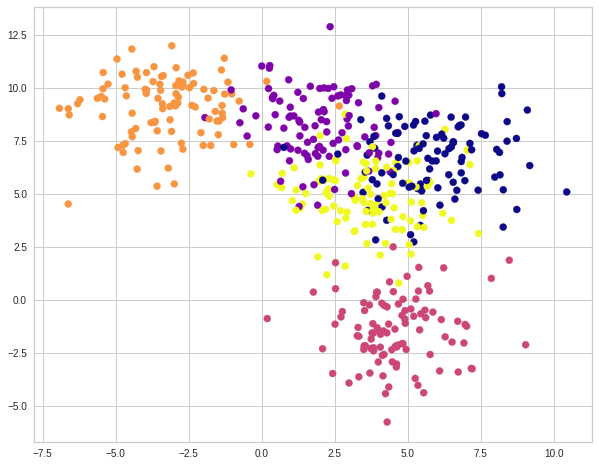

In [4]:
plt.figure(figsize=(10,8))
plt.scatter(X_blob[:,0], X_blob[:,1], s=50, c=y_blob, cmap='plasma')

# Score

In [5]:
results_df = pd.DataFrame(columns=['Homogeneity', 'Completeness', 'Silhouette'])

def accuracy(X, labels, truth=None):
    score_silhouette   = silhouette_score(X, labels, metric='euclidean')
    print('Silhouette   : {:.3f}'.format(score_silhouette))
    
    score_homogeneity = None
    score_completeness = None
    if truth is not None:
        score_homogeneity  = homogeneity_score(labels, truth)
        score_completeness = completeness_score(labels, truth)   
        print('Homogeneity  : {:.3f}'.format(score_homogeneity))
        print('Completeness : {:.3f}'.format(score_completeness))
    
    return score_homogeneity, score_completeness, score_silhouette

def score_model(name, X, labels, truth):
    score = accuracy(X, labels, truth)
    results_df.loc[name] = [*score]

# Hierarchical Clustering
* Agglomerative (AGNES -- Agglomerative Nesting)
  * Work bottom-up
  * Compute pairwise distances of all objects
  * Store each item in leaf
  * Until all members are in root
    * Link closest two objects / clusters in node
* Divisive (DIANA - Divisive Analysis)
  * Work top-down
  * Store all items in root
  * Until all members are in leafs
    * Divide most heterogenous cluster into two
* Consider using when you can't visualize (high dimensional data)

In [6]:
def compute_centroids(X, labels, clusters):
    return np.array( [X[labels == index].mean(0) for index in range(clusters)] )

In [7]:
@interact
def hierarchical_interactive(clusters=(2,10)):
    agg = AgglomerativeClustering(n_clusters=clusters)
    labels = agg.fit_predict(X_blob, y_blob)
    centroids = compute_centroids(X_blob, labels, clusters)
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=labels, s=50, cmap='plasma')
    plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='gray')
    score_model('Agglomerative', X_blob, labels, y_blob)

interactive(children=(IntSlider(value=6, description='clusters', max=10, min=2), Output()), _dom_classes=('wid…

## Distance
* How do we measure the pairwise distances?
  * Euclidian (Default)
  * Cityblock (Manhattan)
  * Cosine, Hamming, etc
* scipy
  * See pdist function
  * Assign in metric argument

In [33]:
# Returned in a compressed flat array
dist_euclidean = pdist(X_blob, metric='euclidean')
dist_euclidean.shape

(124750,)

In [37]:
# Easy to recover to a matrix
squareform(dist_euclidean).shape

(500, 500)

In [23]:
# Distance between two points (euclidean)
print('0', X_blob[0])
print('1', X_blob[1])
math.dist(X_blob[0], X_blob[1])

1 [2.87880574 7.07695868]
2 [-2.99463073  5.46065926]


6.091771475415314

In [34]:
# Finding a location in the condensed form
m = 500
i = 0
j = 1
location = m * i + j - ((i + 2) * (i + 1)) // 2

print('Location', location)
dist_euclidean[location]

Location 0


6.091771475415314

## Linkage
* Performs clustering using distance matrix
* Returns (n - 1) X 4
* Types of linkages
  * Complete (Max) - Max of all pairwise distances between elements in 2 clusters.  Makes clusters that are compact.
  * Single (Min) - Min of all pairwise distances between elements two clusters.  Makes clusters that are loose.  Default.
  * Average - Average distance of pairwise distances between elements in 2 clusters
  * Centroid - Distance between centroids
  * Ward - Minimize total within-cluster variance.  Each step merges the clusters with the minimum between cluster stance.

In [45]:
Z = linkage(X_blob, 'complete')

## Dendrogram
* Reports either index or cluster size (in parentheses)

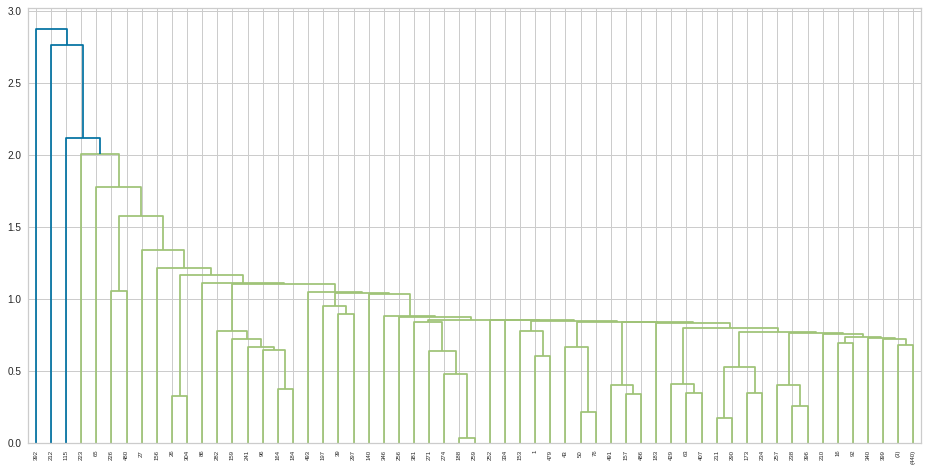

In [38]:
plt.figure(figsize=(16,8))
Z = linkage(X_blob, 'single')
out = dendrogram(Z, truncate_mode='level')

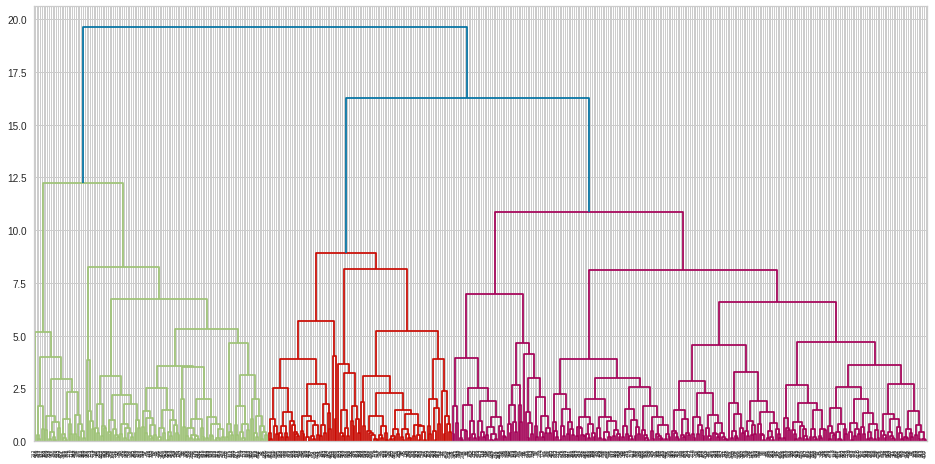

In [39]:
plt.figure(figsize=(16,8))
Z = linkage(X_blob, 'complete')
out = dendrogram(Z, truncate_mode='level')

## Assignment

### Inconsistency
* Be cautious of inconsistency (default criterion in fcluster)
* Inconsistency attempts to find the "biggest" jump
  * inconsistency = height - avg(height) / std(height)
  * where avg and std computed over previous levels
* Problem is that inconsistency depends on depth of the tree

In [91]:
t = 1.1545 # Touchy "knob"
clusters = fcluster(Z, t)
clusters

array([30,  2,  8, 30, 13,  1, 30,  7, 24, 19,  9, 31, 29, 29, 29,  8,  5,
        3,  9, 31,  8, 24,  9, 21, 24,  7,  9,  8,  8,  4,  4,  8,  8,  9,
        1, 19,  7,  3, 32, 10, 26, 30,  6, 12,  3,  4, 24,  8,  8,  8, 12,
        8, 24, 19,  8,  4, 32,  4, 23,  9,  7, 18, 10,  8, 32, 16,  4, 24,
       24, 14, 24,  3, 17, 24, 18,  9, 12,  1,  3,  9, 24,  9,  8, 18, 19,
        3, 11,  8, 24,  8, 24, 22,  5, 24, 22,  8,  8, 15,  9, 18, 32, 27,
       22,  8,  3,  9, 30,  1, 34, 30,  6,  1,  7, 35,  8,  8,  6, 18,  4,
        8,  8, 30,  7,  8,  7,  1, 21,  4, 19, 10,  8,  7,  3,  9,  4,  6,
       18,  1, 18,  7, 24,  8, 18, 30, 24,  9,  8, 24,  9, 30,  1, 24, 24,
        2, 18,  8,  8,  8, 18,  8,  8,  6, 24,  8,  8, 33, 18, 30,  1,  7,
       19,  7,  6, 11, 10,  4, 32, 13, 24,  3, 14, 24,  8,  7,  8,  4, 26,
       26,  8,  1, 24, 17, 30,  1, 26,  3,  1, 10, 30,  8,  6,  7, 24, 30,
        9,  7, 30,  8,  9,  8,  7, 11,  1,  3,  1, 19,  3, 17, 24,  3,  8,
        8, 24,  8, 24, 18

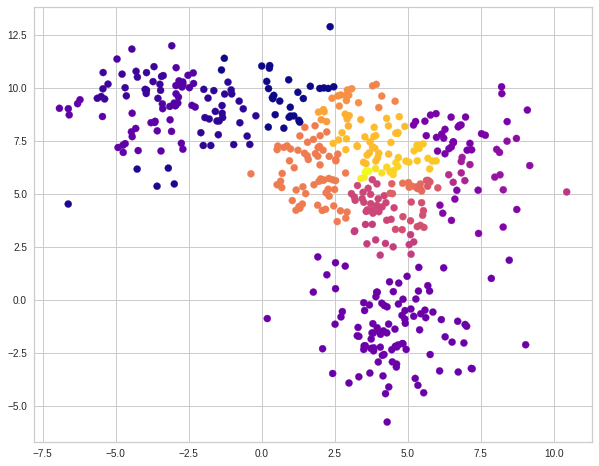

In [89]:
plt.figure(figsize=(10,8))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=clusters, s=50, cmap='plasma')

### Distance Criteria

In [59]:
dist = 10
clusters = fcluster(Z, dist, criterion='distance')
clusters

array([5, 2, 3, 5, 4, 1, 5, 2, 5, 5, 4, 5, 5, 5, 5, 3, 2, 2, 4, 5, 3, 5,
       4, 5, 5, 2, 4, 3, 3, 2, 2, 3, 3, 4, 1, 5, 2, 2, 5, 4, 5, 5, 2, 4,
       2, 2, 5, 3, 3, 3, 4, 3, 5, 5, 3, 2, 5, 2, 5, 4, 2, 5, 4, 3, 5, 4,
       2, 5, 5, 4, 5, 2, 5, 5, 5, 4, 4, 1, 2, 4, 5, 4, 3, 5, 5, 2, 4, 3,
       5, 3, 5, 5, 2, 5, 5, 3, 3, 4, 4, 5, 5, 5, 5, 3, 2, 4, 5, 1, 5, 5,
       2, 1, 2, 5, 3, 3, 2, 5, 2, 3, 3, 5, 2, 3, 2, 1, 5, 2, 5, 4, 3, 2,
       2, 4, 2, 2, 5, 1, 5, 2, 5, 3, 5, 5, 5, 4, 3, 5, 4, 5, 1, 5, 5, 2,
       5, 3, 3, 3, 5, 3, 3, 2, 5, 3, 3, 5, 5, 5, 1, 2, 5, 2, 2, 4, 4, 2,
       5, 4, 5, 2, 4, 5, 3, 2, 3, 2, 5, 5, 3, 1, 5, 5, 5, 1, 5, 2, 1, 4,
       5, 3, 2, 2, 5, 5, 4, 2, 5, 3, 4, 3, 2, 4, 1, 2, 1, 5, 2, 5, 5, 2,
       3, 3, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 3, 3, 4, 1, 3, 2, 3, 5, 2, 3,
       1, 2, 4, 2, 3, 3, 5, 1, 2, 5, 4, 2, 5, 3, 2, 3, 5, 3, 5, 5, 2, 5,
       5, 4, 5, 3, 3, 2, 1, 3, 5, 3, 3, 3, 5, 5, 5, 5, 5, 3, 3, 5, 5, 3,
       5, 5, 2, 1, 4, 2, 4, 3, 4, 3, 4, 4, 5, 5, 5,

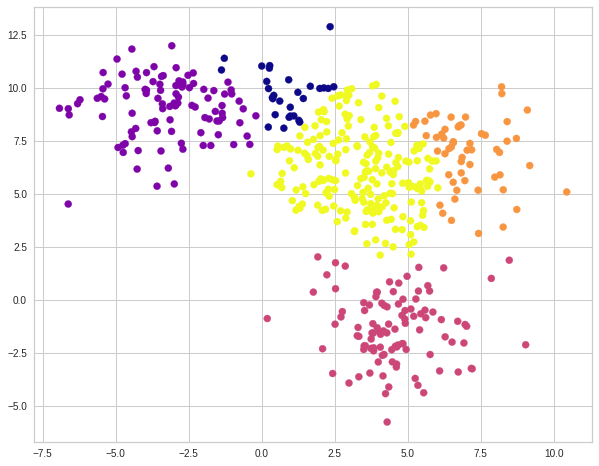

In [60]:
plt.figure(figsize=(10,8))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=clusters, s=50, cmap='plasma')

### K Clusters

In [63]:
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([5, 2, 3, 5, 4, 1, 5, 2, 5, 5, 4, 5, 5, 5, 5, 3, 2, 2, 4, 5, 3, 5,
       4, 5, 5, 2, 4, 3, 3, 2, 2, 3, 3, 4, 1, 5, 2, 2, 5, 4, 5, 5, 2, 4,
       2, 2, 5, 3, 3, 3, 4, 3, 5, 5, 3, 2, 5, 2, 5, 4, 2, 5, 4, 3, 5, 4,
       2, 5, 5, 4, 5, 2, 5, 5, 5, 4, 4, 1, 2, 4, 5, 4, 3, 5, 5, 2, 4, 3,
       5, 3, 5, 5, 2, 5, 5, 3, 3, 4, 4, 5, 5, 5, 5, 3, 2, 4, 5, 1, 5, 5,
       2, 1, 2, 5, 3, 3, 2, 5, 2, 3, 3, 5, 2, 3, 2, 1, 5, 2, 5, 4, 3, 2,
       2, 4, 2, 2, 5, 1, 5, 2, 5, 3, 5, 5, 5, 4, 3, 5, 4, 5, 1, 5, 5, 2,
       5, 3, 3, 3, 5, 3, 3, 2, 5, 3, 3, 5, 5, 5, 1, 2, 5, 2, 2, 4, 4, 2,
       5, 4, 5, 2, 4, 5, 3, 2, 3, 2, 5, 5, 3, 1, 5, 5, 5, 1, 5, 2, 1, 4,
       5, 3, 2, 2, 5, 5, 4, 2, 5, 3, 4, 3, 2, 4, 1, 2, 1, 5, 2, 5, 5, 2,
       3, 3, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 3, 3, 4, 1, 3, 2, 3, 5, 2, 3,
       1, 2, 4, 2, 3, 3, 5, 1, 2, 5, 4, 2, 5, 3, 2, 3, 5, 3, 5, 5, 2, 5,
       5, 4, 5, 3, 3, 2, 1, 3, 5, 3, 3, 3, 5, 5, 5, 5, 5, 3, 3, 5, 5, 3,
       5, 5, 2, 1, 4, 2, 4, 3, 4, 3, 4, 4, 5, 5, 5,

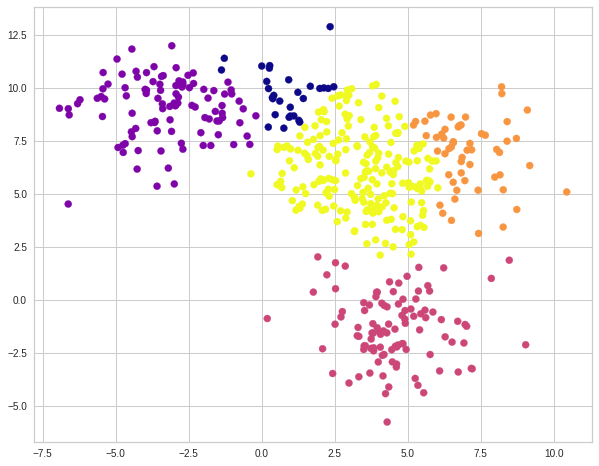

In [64]:
plt.figure(figsize=(10,8))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=clusters, s=50, cmap='plasma')

## Quality
* An additional measure of quality is to look at the correlation of 
  * The cophenetic distance 
  * Original distance metric
* Cophenetic distance measures how closely a dendrogram preserves pairwise distances of original data

In [75]:
dist = pdist(X_blob, metric='euclidean')
Z = linkage(X_blob, 'single')
score, b = cophenet(Z, dist)
print('Score Single Linkage', score)

Score Single Linkage 0.3357001338275949


In [45]:
dist = pdist(X_blob, metric='euclidean')
Z = linkage(X_blob, 'complete')
score, b = cophenet(Z, dist)
print('Score Complete Linkage', score)

0.7249244944555059

In [53]:
dist = pdist(X_blob, metric='cosine')
Z = linkage(X_blob, 'complete')
score, b = cophenet(Z, dist)
print('Score Complete Linkage, Cosine', score)

Score Complete Linkage, Cosine 0.5606265157529177


# Density-Based Clustering

## DBSCAN
* Density Based Spatial Clusting of Applications with Noise
  * Clusters can be any shape
  * Cluster is a set of core samples close to each other (Min Samples within EPS of eachother)
  * Cluster has a set of non-core samples that are close to a core sample
* Key Parameters
  * EPS = maximum distance for two points (core samples)
  * MIN_SAMPLES = minimum number of samples to be called a cluster
  * Low EPS or high MIN_SAMPLES indicates higher density
  * As you increase MIN_SAMPLES, the number of clusters tends to go down
  * If EPS is too low, you tend to see more outliers
* Deterministic
  * If the order of the data remains the same, the clusters will be identical
  * If order changes, the labels can change and samples "may" jump clusters
* Advantages
  * Don't need number of clusters
  * Finds outliers!
* Limitations
  * Setting EPS and Min Cluster size
  * Memory on large datasets (default = full pairwise similarity matrix)

In [74]:
@interact
def dbscan_interactive(EPS=(0.1, 3.0), MIN_SAMPLES=(1,30)):
    warnings.filterwarnings('ignore')
    dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
    dbscan_labels = dbscan.fit_predict(X_blob)
    dbscan_centroids = compute_centroids(X_blob, dbscan_labels, len(set(dbscan_labels)))
    
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=dbscan_labels, s=50, cmap='plasma')
    plt.scatter(dbscan_centroids[:, 0], dbscan_centroids[:, 1], s=100, c='gray')
    
    print('Clusters {}'.format(len(set(dbscan_labels))))
    score_model('DBSCAN', X_blob, dbscan_labels, y_blob)

interactive(children=(FloatSlider(value=1.55, description='EPS', max=3.0, min=0.1), IntSlider(value=15, descri…

### Algorithm
* For each point, compute pairwise distances
  * Find points within EPS distance)
  * If points > MIN_CLUSTER mark as core point
* For each core point
  * If not in existing cluster, mark as new cluster
  * Recursively label all densely connected points as same cluster
* Points that fall outside of clusters are labeled as outliers

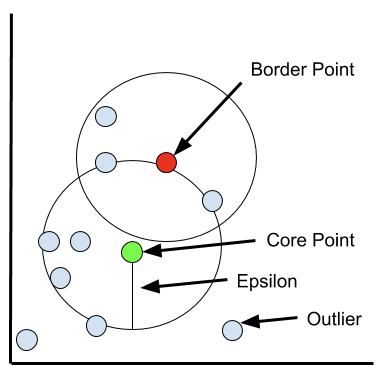

### Finding EPS
* A possible approach involves the knn distplot
* Compute at the average distance between each point an its k nearest neighbors
* Set k equal to the min cluster size
* Look for the knee (where sharp change in distance occurs)
* https://github.com/vincewide/ML_scheduler/blob/a9225d15dcbbbbfc3ffefa58560369cbf0f9f704/DBSCAN.py#L55

In [70]:
def compute_distance_mean(points, min_pts, previous_distance_mean):
    """
    Method used to calculate the mean of the neighbors distances
    
    :param points: List containing the training-points you want to use
    :param minPts: Minimum number of points to be considered a cluster
    :param previous_distanceMean: The previous mean of the distances
    :return: Average distance between the points
    """
    
    if (min_pts < len(points)):
        nbrs = NearestNeighbors(n_neighbors=min_pts).fit(points)
        distances, indices = nbrs.kneighbors(points)
        d_mean = distances.mean()
        return d_mean
    else:
        return previous_distance_mean
        

def knn_distplot(points, min_pts):
    """
    Calculate where the slope of the knn distplot is higher than a user-defined
    value while plotting the K-NN distance with respect to the amount of 
    training data
    
    :param points: List containing the points you want to use
    :param minPts: Minimum number of points to be considered a cluster
    :return: The most optimal parameter-values i.e Knee point values
    """
    n_training_data = 0
    eps_plot = []
    current_distance_mean = previous_distance_mean = 0
    knee_value = knee_found = 0

    for i in range (0, len(points), 5):
        current_distance_mean = compute_distance_mean(points[i:], min_pts, previous_distance_mean)
        df = current_distance_mean - previous_distance_mean
        
        if (df > 0.02 and i > 1 and knee_found == 0):
            knee_value = current_distance_mean
            knee_found = 1
            n_trainingData = i
            
        eps_plot.append( [i,current_distance_mean] )
        previous_distance_mean = current_distance_mean
     
    #Plot
    for i in range(0, len(eps_plot)):
                plt.scatter(eps_plot[i][0],eps_plot[i][1],c='r',s=3,marker='o')
    
    plt.title(f'Min Cluster Size {min_pts}')
    plt.axhline(y=knee_value, color='g', linestyle='-')
    plt.axvline(x=n_training_data , color='g', linestyle='-')
    plt.show()
    print(f'Knee value: x={n_trainingData} y={knee_value}')
    return knee_value

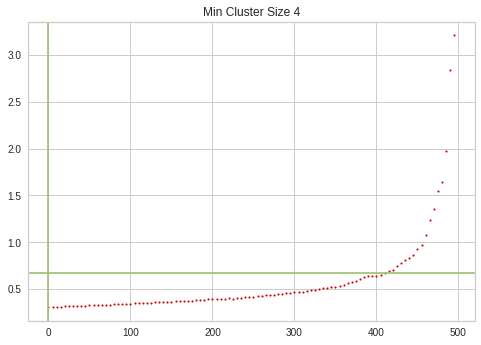

Knee value: x=410 y=0.67604568440258


0.67604568440258

In [72]:
knn_distplot(X_blob, 4)

### Finding Min Points
* Heuristic - At least the number of features
* Consider - Features * 2 as starting point
* Testing - Elbow (Knee) Method

## HDBSCAN
* https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
* Extension of DBSCAN using Heirarchical clustering

In [40]:
@interact
def hdbscan_interactive(MIN_CLUSTER_SIZE=(30), MIN_SAMPLES=(30)):
    warnings.filterwarnings('ignore')
    hdb = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, 
                          min_samples=MIN_SAMPLES)
    hdb_labels = hdb.fit_predict(X_blob)
    hdb_centroids = compute_centroids(X_blob, hdb_labels, len(set(hdb_labels)))
    
    print('Clusters {}'.format(len(set(hdb_labels))))
    score_model('HDBSCAN', X_blob, hdb_labels, y_blob)
    
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=hdb_labels, s=50, cmap='plasma')
    plt.scatter(hdb_centroids[:, 0], hdb_centroids[:, 1], s=100, c='gray')
    plt.show()
    
    plt.figure(figsize=(10,8))
    hdb.single_linkage_tree_.plot(cmap='plasma', p=10, truncate_mode='lastp')

interactive(children=(IntSlider(value=30, description='MIN_CLUSTER_SIZE', max=90, min=-30), IntSlider(value=30…

In [41]:
@interact
def show_results(SORT=['Completeness', 'Homogeneity', 'Silhouette']):
    print(results_df.sort_values(SORT, ascending=False))

interactive(children=(Dropdown(description='SORT', options=('Completeness', 'Homogeneity', 'Silhouette'), valu…

# Performance
* https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html
* Spectral, Affinity and Agglomerative usable under 10,000 data points
* Fastcluster extends the use of heirarchal clustering
* Scikit KMeans > scipy KMeans (requires # of clusters)
* HDBSCAN > DBSCAN (does not require # of clusters)

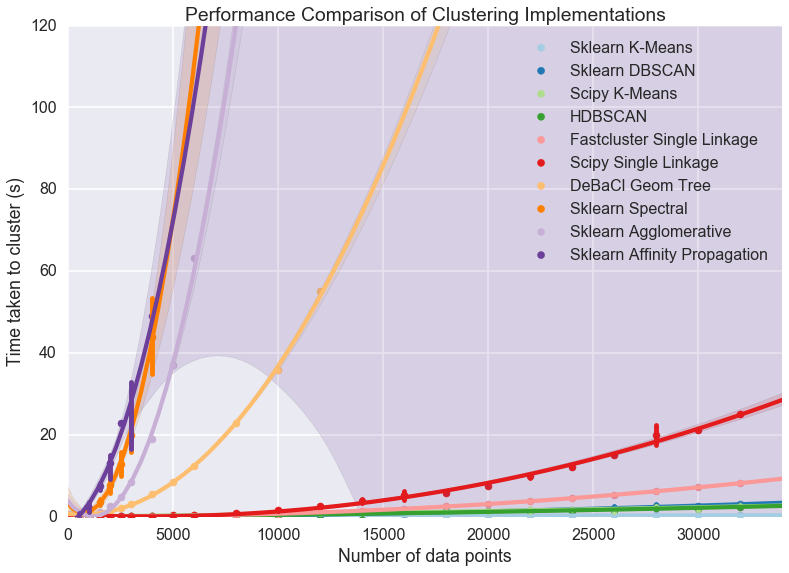

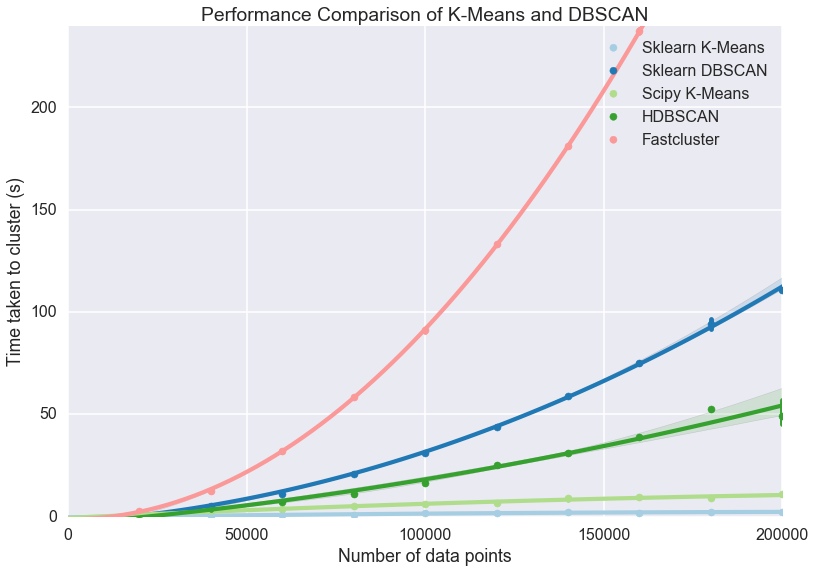

# Tips

* Be mindful of the dataset size
  * Small < 10,000 KMeans, (H)DBScan, Agglomerative(scipy, sklearn, fastecluster), Spectral & Affinity
  * Large > 10,000 KMeans, (H)DBScan, Agglomerative(fastcluster)
  * Very Large > 100,000 MiniBatchKMeans
* Know basic characteristics & weaknesses
  * KMeans
    * Know # clusters
    * Non-convex clusters
    * Mini-batch for huge datasets
    * Will converge - but could be a local minima
    * Use kmeans++ (ensures starting centroids are distant)
  * Agglomerative - Bottom up, generally builds good clusters, slow, use fastcluster
  * DBScan - Clusters of different densities (tuning EPS), Outliers
  * Spectral - Performs well, until you have 10k datapoints